In [2]:
import torch_geometric

import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv
from torch_geometric.data import Data, DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import scipy.sparse as sp

import warnings
warnings.filterwarnings("ignore")

# ref: https://medium.com/stanford-cs224w/fraud-detection-with-gat-edac49bda1a0

#### Import dataset

In [3]:
# import data 
df_features = pd.read_csv('../data/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv("../data/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("../data/elliptic_txs_classes.csv")

df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})

# merging dataframes
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge.drop(0, axis=1, inplace=True)

# check if there are duplicate txId
print("Number of duplicate txId: ", df_merge.duplicated(subset=['txId']).sum())


Number of duplicate txId:  0


In [4]:
# rename column 0 to time_step
df_merge.rename(columns={1: 'time_step'}, inplace=True)
display(df_merge.head())
display(df_edges.shape)

,time_step,2,3,4,5,6,7,8,9,10,...,159,160,161,162,163,164,165,166,txId,class
0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230425980,2
1,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,2
2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,2
3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,0
4,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,...,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,2


(234355, 2)

In [13]:
df_merge.shape

(203769, 168)

#### Split dataset masks

In [5]:
edges = df_edges.copy()

# Setup trans ID to node ID mapping
nodes = df_merge['txId'].values
map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

# Map transction IDs to node Ids
edges.txId1 = edges.txId1.map(map_id) #get nodes idx1 from edges list and filtered data
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

# Reformat and convert to tensor
edge_index = np.array(edges.values).T 
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

print("shape of edge index is {}".format(edge_index.shape))

shape of edge index is torch.Size([2, 234355])


In [6]:
node_features = df_merge.drop(['txId'], axis=1).copy()
print("unique=",node_features["class"].unique())

# Retain known vs unknown IDs
all_classified_idx = node_features['class'].loc[node_features['class']!=2].index # filter on known labels
all_unclassified_idx = node_features['class'].loc[node_features['class']==2].index
all_classified_illicit_idx = node_features['class'].loc[node_features['class']==1].index # filter on illicit labels
all_classified_licit_idx = node_features['class'].loc[node_features['class']==0].index # filter on licit labels

# node_features = node_features.drop(columns=[0, 1, 'class'])
display(node_features.head())

unique= [2 0 1]


,time_step,2,3,4,5,6,7,8,9,10,...,158,159,160,161,162,163,164,165,166,class
0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
1,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,2
3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
4,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,2


In [7]:
train_classified_idx = node_features.loc[(node_features['time_step'] <= 34) & (node_features['class'] != 2)].index
test_classified_idx = node_features.loc[(node_features['time_step'] > 34) & (node_features['class'] != 2)].index
print("train_classified_idx.shape=",train_classified_idx.shape)
print("test_classified_idx.shape=",test_classified_idx.shape)

train_classified_idx.shape= (29894,)
test_classified_idx.shape= (16670,)


In [8]:
# show ratio of illicit vs licit transactions in train and test set
train_classified_illicit_idx = node_features.loc[(node_features['time_step'] <= 34) & (node_features['class'] == 1)].index
train_classified_licit_idx = node_features.loc[(node_features['time_step'] <= 34) & (node_features['class'] == 0)].index
print("train_classified_illicit_idx.shape=",train_classified_illicit_idx.shape)
print("train_classified_licit_idx.shape=",train_classified_licit_idx.shape)
print("train_classified_illicit_idx.shape[0]/train_classified_idx.shape[0]=",train_classified_illicit_idx.shape[0]/train_classified_idx.shape[0])

train_classified_illicit_idx.shape= (3462,)
train_classified_licit_idx.shape= (26432,)
train_classified_illicit_idx.shape[0]/train_classified_idx.shape[0]= 0.11580919248009634


In [8]:
# save the train and test indices as csv, integer
np.savetxt("../data/index/train_classified_idx.csv", train_classified_idx, delimiter=",", fmt='%d')
np.savetxt("../data/index/test_classified_idx.csv", test_classified_idx, delimiter=",", fmt='%d')

In [9]:
temp_node_features = node_features.copy()
# node_features.drop(columns=['time_step'], inplace=True)
node_features.drop(columns=['class'], inplace=True)

# Convert to tensor
node_features_t = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)

In [12]:
node_features_t.shape

torch.Size([203769, 166])

In [10]:
# Define labels
labels = df_merge['class'].values

#create weights tensor with same shape of edge_index
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double) 

# Do train test split on classified_ids
train_idx = train_classified_idx
test_idx = test_classified_idx

# Create pyG dataset
data_graph = Data(x=node_features_t.float(), edge_index=edge_index, edge_attr=weights, 
                               y=torch.tensor(labels, dtype=torch.long))

# Add in the train and valid idx
data_graph.train_idx = train_idx
data_graph.test_idx = test_idx
data_graph

Data(x=[203769, 166], edge_index=[2, 234355], edge_attr=[234355], y=[203769], train_idx=Int64Index([     3,      9,     10,     11,     16,     17,     25,     27,
                29,     30,
            ...
            136232, 136233, 136234, 136236, 136239, 136241, 136243, 136249,
            136250, 136258],
           dtype='int64', length=29894), test_idx=Int64Index([136276, 136277, 136278, 136279, 136280, 136282, 136285, 136287,
            136288, 136291,
            ...
            203727, 203730, 203736, 203740, 203750, 203752, 203754, 203759,
            203763, 203766],
           dtype='int64', length=16670))

#### GCN Model and Training

In [11]:
# 2-layer GCN
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=128):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
CLASS_WEIGTHS = [0.7,0.3]

def train(model, data, optimizer):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    # out = out.reshape((data.x.shape[0]))
    # use weighted cross entropy loss, weighted cross entropy loss to provide higher importance to the illicit samples.
    weights = torch.tensor(CLASS_WEIGTHS, dtype=torch.float).to(device)
    loss = F.cross_entropy(out[data.train_idx], data.y[data.train_idx], weight=weights)
    loss.backward()
    optimizer.step()
    return loss

def test(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        out = model(data.x, data.edge_index)
        pred_scores = out[data.test_idx]
        pred = torch.argmax(pred_scores, dim=1)
        y = data.y[data.test_idx]
        # metrics for illicit transactions
        acc = accuracy_score(y.cpu(), pred.cpu())
        f1 = f1_score(y.cpu(), pred.cpu(), average='binary')
        precision = precision_score(y.cpu(), pred.cpu(), average='binary')
        recall = recall_score(y.cpu(), pred.cpu(), average='binary')
        return acc, f1, precision, recall
    

In [14]:
num_features = data_graph.num_node_features
print("num_features=",num_features)

num_features= 166


In [15]:
model = GCN(num_features, 2).to(device)
num_epochs = 500
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs+1):
    loss = train(model, data_graph, optimizer)
    acc, f1, precision, recall = test(model, data_graph)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Epoch: 000, Loss: 2.0221, Accuracy: 0.6476, F1: 0.0796, Precision: 0.0479, Recall: 0.2345
Epoch: 010, Loss: 0.2530, Accuracy: 0.9337, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 020, Loss: 0.2040, Accuracy: 0.9307, F1: 0.0103, Precision: 0.0706, Recall: 0.0055
Epoch: 030, Loss: 0.1719, Accuracy: 0.8454, F1: 0.2714, Precision: 0.1956, Recall: 0.4432
Epoch: 040, Loss: 0.1554, Accuracy: 0.8975, F1: 0.2128, Precision: 0.2123, Recall: 0.2133
Epoch: 050, Loss: 0.1504, Accuracy: 0.9055, F1: 0.1775, Precision: 0.2041, Recall: 0.1570
Epoch: 060, Loss: 0.1471, Accuracy: 0.8627, F1: 0.2661, Precision: 0.2038, Recall: 0.3832
Epoch: 070, Loss: 0.1447, Accuracy: 0.8918, F1: 0.2212, Precision: 0.2078, Recall: 0.2364
Epoch: 080, Loss: 0.1431, Accuracy: 0.8744, F1: 0.2612, Precision: 0.2114, Recall: 0.3416
Epoch: 090, Loss: 0.1420, Accuracy: 0.8791, F1: 0.2523, Precision: 0.2109, Recall: 0.3139
Epoch: 100, Loss: 0.1409, Accuracy: 0.8764, F1: 0.2616, Precision: 0.2138, Recall: 0.3370
Epoch: 110

Accuracy: 0.9140, F1: 0.3778, Precision: 0.3566, Recall: 0.4017


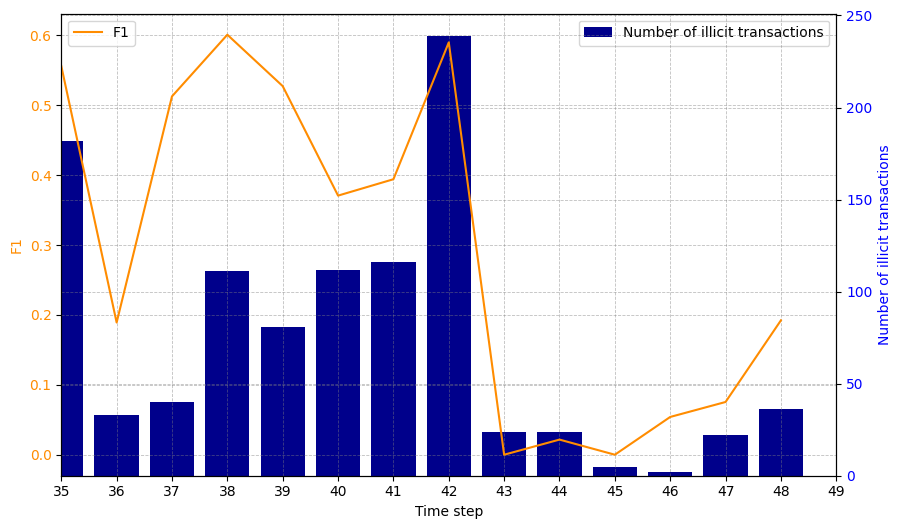

In [16]:
# test 
acc, f1, precision, recall = test(model, data_graph)
print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
# test results on each time step of the test set and number of illicit transactions in each time step
# dict of test results on each time step and number of illicit transactions in each time step
test_results = {}

for t in range(35, 49):
    test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] != 2)].index
    data_graph.test_idx = test_classified_idx
    acc, f1, precision, recall = test(model, data_graph)
    num_illicit = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] == 1)].shape[0]
    test_results[t] = [num_illicit, f1, acc, precision, recall]
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Changing bar color to dark blue and line color to solid orange
ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='darkblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='darkorange')
ax1.set_xlim(35, 49)
# Legend
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

# Changing y-label colors to match their corresponding plot elements
ax1.set_ylabel('F1', color='darkorange')
ax2.set_ylabel('Number of illicit transactions', color='blue')

# Changing tick colors to match their corresponding plot elements
ax1.tick_params(axis='y', labelcolor='darkorange')
ax2.tick_params(axis='y', labelcolor='blue')

# Show every tick number
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Enhancing grid visibility
ax1.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)

# To put ax1 (F1 line) in the front
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)

plt.show()


In [62]:
indices = ((data_graph.y == 0).nonzero(as_tuple=True))[0].to(torch.float)
num_samples = 5
random_indices = torch.multinomial(indices, num_samples, replacement=True)
random_elements = indices[random_indices]
random_elements

indices = ((data_graph.y == 1).nonzero(as_tuple=True))[0].to(torch.float)
num_samples = 5
random_indices = torch.multinomial(indices, num_samples, replacement=True)
random_elements_2 = indices[random_indices]
ind = torch.cat((random_elements, random_elements_2), dim=0).to(torch.int)
ind.tolist()


# indices = ((data_graph.y == 1).nonzero(as_tuple=True))[0]
# ind.append(random.sample(indices, 5))

# ind

[155415, 125501, 137042, 142209, 169716, 51114, 49784, 171678, 126657, 159336]

In [34]:
indices = (data_graph.y == 0).nonzero(as_tuple=True)
indices = indices[0]
# illicit 
indices[200]

tensor(706)

In [63]:
# ind = [706, 5602, 7466, 102794, 191531, 907, 1361, 2718, 203736, 203766]
# ind = [116, 198, 224, 650, 808, 1017, 1706, 1733, 2172, 2433]
ind = [155415, 125501, 137042, 142209, 169716, 51114, 49784, 171678, 126657, 159336]
feat = data_graph.x[ind]
feat.shape

torch.Size([10, 166])

In [64]:
from torch_geometric.explain import Explainer, GNNExplainer


explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

exp = []
# explanations for each node
for i in ind:
    explanation = explainer(data_graph.x, data_graph.edge_index, index=i)
    exp.append(explanation)
############################

In [66]:
for e in exp:
    path = f'features/feat_{e.index}.png'
    e.visualize_feature_importance(path, top_k=50)

In [52]:
from torch_geometric.nn import MessagePassing, APPNP
from torch_geometric.utils import k_hop_subgraph

def subgraph(model, node_idx, x, edge_index, **kwargs):
    num_nodes, num_edges = x.size(0), edge_index.size(1)

    flow = 'source_to_target'
    for module in model.modules():
        if isinstance(module, MessagePassing):
            flow = module.flow
            break

    num_hops = 0
    for module in model.modules():
        if isinstance(module, MessagePassing):
            if isinstance(module, APPNP):
                num_hops += module.K
            else:
                num_hops += 1

    subset, edge_index, mapping, edge_mask = k_hop_subgraph(
        node_idx, num_hops, edge_index, relabel_nodes=True,
        num_nodes=num_nodes, flow=flow)

    x = x[subset]
    for key, item in kwargs:
        if torch.is_tensor(item) and item.size(0) == num_nodes:
            item = item[subset]
        elif torch.is_tensor(item) and item.size(0) == num_edges:
            item = item[edge_mask]
        kwargs[key] = item

    return x, edge_index, mapping, edge_mask, kwargs

def edge_mask_to_node_mask(data, edge_mask, aggregation="mean"):

    node_weights = torch.zeros(data.x.shape[0])

    if aggregation == "sum":

        for weight, nodes in zip(edge_mask, data.edge_index.T):
            node_weights[nodes[0].item()] += weight.item() / 2
            node_weights[nodes[1].item()] += weight.item() / 2

    elif aggregation == "mean":

        node_degrees = torch.zeros(data.x.shape[0])

        for weight, nodes in zip(edge_mask, data.edge_index.T):

            node_weights[nodes[0].item()] += weight.item()

            node_weights[nodes[1].item()] += weight.item()

            node_degrees[nodes[0].item()] += 1

            node_degrees[nodes[1].item()] += 1

        node_weights = node_weights / node_degrees.clamp(min=1.)

    elif aggregation == "max":

        for weight, nodes in zip(edge_mask, data.edge_index.T):

            node_weights[nodes[0].item()] = max(weight.item(), node_weights[nodes[0].item()])

            node_weights[nodes[1].item()] = max(weight.item(), node_weights[nodes[1].item()])

    else:

        raise NotImplementedError(f"No such aggregation method: {aggregation}")

    return node_weights

# convert the edge mask to node mask here
def generate_node_masks(explainer, nodes, data, aggregation="mean"):
    node_masks = []

    for node in nodes:
        _, edge_mask = explainer.explain_node(node, data.x, data.edge_index)
        node_mask = edge_mask_to_node_mask(data, edge_mask, aggregation)
        node_masks.append(node_mask)
        
    return node_masks

# The function to return the k-hop subgraph of the selected nodes
def fidelity(model,  # is a must
             node_idx,  # is a must
             full_feature_matrix,  # must
             edge_index=None,  # the whole, so data.edge_index
             node_mask=None,  # at least one of these three node, feature, edge
             feature_mask=None,
             edge_mask=None,
             samples=100,
             random_seed=12345,
             device="cpu"
             ):
    """
    Distortion/Fidelity (for Node Classification)
    :param model: GNN model which is explained
    :param node_idx: The node which is explained
    :param full_feature_matrix: The feature matrix from the Graph (X)
    :param edge_index: All edges
    :param node_mask: Is a (binary) tensor with 1/0 for each node in the computational graph
    => 1 means the features of this node will be fixed
    => 0 means the features of this node will be pertubed/randomized
    if not available torch.ones((1, num_computation_graph_nodes))
    :param feature_mask: Is a (binary) tensor with 1/0 for each feature
    => 1 means this features is fixed for all nodes with 1
    => 0 means this feature is randomized for all nodes
    if not available torch.ones((1, number_of_features))
    :param edge_mask:
    :param samples:
    :param random_seed:
    :param device:
    :param validity:
    :return:
    """
    if edge_mask is None and feature_mask is None and node_mask is None:
        raise ValueError("At least supply one mask")

    computation_graph_feature_matrix, computation_graph_edge_index, mapping, hard_edge_mask, kwargs = subgraph(model, node_idx, 
                                                                                                               full_feature_matrix, 
                                                                                                               edge_index)

    # get predicted label
    log_logits = model.forward(x=computation_graph_feature_matrix,
                               edge_index=computation_graph_edge_index)
    predicted_labels = log_logits.argmax(dim=-1)

    predicted_label = predicted_labels[mapping]

    # fill missing masks
    if feature_mask is None:
        (num_nodes, num_features) = full_feature_matrix.size()
        feature_mask= torch.ones((1, num_features), device=device)

    num_computation_graph_nodes = computation_graph_feature_matrix.size(0)
    if node_mask is None:
        # all nodes selected
        node_mask = torch.ones((1, num_computation_graph_nodes), device=device)


    # set edge mask
    if edge_mask is not None:
        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = edge_mask
    (num_nodes, num_features) = full_feature_matrix.size()

    num_nodes_computation_graph = computation_graph_feature_matrix.size(0)

    # retrieve complete mask as matrix
    mask = node_mask.T.matmul(feature_mask)

    correct = 0.0

    rng = torch.Generator(device=device)
    rng.manual_seed(random_seed)
    random_indices = torch.randint(num_nodes, (samples, num_nodes_computation_graph, num_features),
                                   generator=rng,
                                   device=device,
                                   )
    random_indices = random_indices.type(torch.int64)
    
    
    ###################################################################################################
    # for each samples, add your code here to:
    for i in range(samples):

        #1. generate the perturbed input
        random_features = torch.gather(full_feature_matrix,
                                       dim=0,
                                       index=random_indices[i, :, :])

        randomized_features = mask * computation_graph_feature_matrix + (1 - mask) * random_features

        #2. get the prediction from the trained model using the perturbed features as input
        log_logits = model(x=randomized_features, edge_index=computation_graph_edge_index)

        #3. calculate the number of corrected predicted labels:
        distorted_labels = log_logits.argmax(dim=-1)
        if distorted_labels[mapping] == predicted_label:
            correct += 1       
    ###################################################################################################
    
    # reset mask
    if edge_mask is not None:
        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None

    return correct / samples

In [65]:
# for each node calculate the rdt fidelity for the feature and node mask

# Initialize empty lists to store the results
fidelity_scores = []
device = torch.device('cpu')

# Loop over each node
for idx, explanation in zip(ind, exp):
    # Generate masks for GNNExplainer
    node_feat_mask = explanation.node_mask
    # print(node_feat_mask)
    edge_mask = explanation.edge_mask

    node_mask = edge_mask_to_node_mask(data_graph, edge_mask, aggregation="mean")

    # Calculate fidelity
    fidelity_score = fidelity(model, 
                              node_idx=idx, 
                              full_feature_matrix=data_graph.x, 
                              edge_index=data_graph.edge_index, 
                              node_mask=node_mask, 
                              edge_mask=edge_mask,
                              feature_mask=node_feat_mask,
                              device=device)
    fidelity_scores.append(fidelity_score)

# Print out the results
for i, fid in zip(ind, fidelity_scores):
    print(f'Node {i} - Fidelity: {fid}')

Node 155415 - Fidelity: 1.0
Node 125501 - Fidelity: 0.78
Node 137042 - Fidelity: 1.0
Node 142209 - Fidelity: 0.96
Node 169716 - Fidelity: 0.87
Node 51114 - Fidelity: 0.99
Node 49784 - Fidelity: 1.0
Node 171678 - Fidelity: 0.97
Node 126657 - Fidelity: 0.96
Node 159336 - Fidelity: 0.27
